# Import

In [1]:
from numpy import mean
from numpy import std
from numpy import dstack
from pandas import read_csv
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.utils import to_categorical
from keras import backend as K

from sklearn.metrics import mean_squared_error
import time

In [2]:
#from google.colab import drive
#drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from functools import partial
from scipy import stats
import pickle

import tensorflow as tf
#import tensorflow_addons as tfa

from tqdm import tqdm
from scipy.integrate import solve_ivp
import pickle


# Load Data

In [7]:
# Read dictionary pkl file
with open('Training_Test_Sets/One_Step_Simulated_Data_Dist.pkl', 'rb') as fp:
    d = pickle.load(fp)

In [8]:
#mY = d['next_step'].max(axis = 0)
#mX = d['Prior'].max(axis = 0)

mX = [6000,3500,6000,1500,10,3500]
mX = [0.1*m+m for m in mX]
#mY = mX[2:]
mY = [1,4,600,1.7]
#normalized_dataY = np.divide(d['next_step'],mX[2:])
normalized_dataY = (d['next_step'])*mY
normalized_dataX = np.divide(d['Prior'],mX)

In [9]:
training_data = {}
valid_data = {}
training_data['prior_draws'] = normalized_dataX[3200:67200]
training_data['sim_data'] = normalized_dataY[3200:67200]
valid_data['prior_draws'] = np.concatenate((normalized_dataX[0:320],normalized_dataX[67200:70400]),axis = 0)
valid_data['sim_data'] = np.concatenate((normalized_dataY[0:320],normalized_dataY[67200:70400]), axis =0)

In [10]:
#trainX = training_data['prior_draws'].reshape((64000,6,1))
trainX = training_data['prior_draws']
trainY = training_data['sim_data']

#testX = valid_data['prior_draws'].reshape((320,6,1))
testX = valid_data['prior_draws']
testY = valid_data['sim_data']

# Simple Neural Model

In [ ]:
#tqdm_callback = tfa.callbacks.TQDMProgressBar()

In [6]:
# fit and evaluate a model
def set_model(trainX, trainy, testX, testy):
 n_outputs = trainy.shape[1]
 model = Sequential()
 model.add(Dense(24, activation='relu'))
 model.add(Dense(32, activation='relu'))
 model.add(Dense(32, activation='relu'))
 model.add(Dense(24, activation='relu'))
 #model.add(Dropout(0.5))
 model.add(Dense(n_outputs, activation='linear'))
 return model

In [11]:
epochs, batch_size = 3000, 64
model = set_model(trainX, trainY, testX, testY)
model.compile(loss='MeanSquaredError', optimizer=tf.keras.optimizers.Adam(0.0001), metrics=['accuracy'])

In [ ]:
K.set_value(model.optimizer.learning_rate, 0.0001)

In [12]:
checkpoint_path = '/content/drive/MyDrive/Team_Project/Checkpoint/NN'

try:
  model.load_weights(checkpoint_path)
except:
  print("No Pretrained model")

cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=0)

No Pretrained model


In [13]:
# fit network
model.fit(trainX, trainY, epochs=1, batch_size=64, verbose=1, validation_data=(testX, testY),callbacks=[cp_callback])

1000/1000 [==============================] - 8s 5ms/step - loss: 9396772.0000 - accuracy: 0.1786 - val_loss: 8210783.5000 - val_accuracy: 0.1685


# Test

In [ ]:
N_ext = 3000
D_ext = 2700
Initial = [N_ext, D_ext, 1000 , 3, 2, 450]

In [ ]:
def prior_sample_test(Initial):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = Initial[0]
    D_ext = Initial[1]
    N_0 = Initial[2]
    I_0 = Initial[3]
    E_0 = Initial[4]
    D_0 = Initial[5]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [ ]:
def ode_system(t, y, D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0):
  N,I,E,D = y
  Nt_dt = (N0 * (1+(I**p/(I0**p+I**p)))) - (kc * N * D) - (kt * N * D_ext) - gamma * N
  It_dt = (kt * N * D_ext) - (gamma_I * I)
  Et_dt = (1 * (I**p/(I0**p+I**p))) - (gamma * E)
  Dt_dt = (D0 * (I0**p/(I0**p+I**p))) - (kc*N*D) - (kt * N_ext * D) - (gamma * D)
  return [Nt_dt, It_dt, Et_dt, Dt_dt]

In [ ]:
def Nonlinear_Solver(params, T, p = 2,
                     kc = 5.e-4,kt = 5.e-5,
                     gamma = 0.1,gamma_I = 0.5,
                     N0 = 500,I0 = 200, E0 = 1, D0 = 1000,
                     scale_I = 100, scale_N = 1000, scale_E = 0.25, scale_D = 3000):
  """Performs a forward simulation with LSODA method using solve_ivp for the Nonlinear ODE model given a random draw from the prior,"""
  # Extract parameters
  N_ext = params[0]
  D_ext = params[1]
  # Initial conditions
  initial_cond = [params[2],params[3],params[4],params[5]]
  # Simulate T+1 timesteps
  time = (0,T)
  solution = solve_ivp(ode_system,time, initial_cond, method='LSODA', args=(D_ext, N_ext, p, kc, kt, gamma, gamma_I, N0, I0, E0, D0),max_step=0.01)
  t = solution.t
  N_sol, I_sol, E_sol, D_sol = solution.y
  #return np.stack([N_sol/scale_N, I_sol/scale_I, E_sol/scale_E, D_sol/scale_D])
  return np.stack([N_sol, I_sol, E_sol, D_sol])

In [ ]:
def test_1(N,N_time_steps):
  data = {}
  data['Prior'] = np.ndarray((0,6))
  data['next_step'] = np.zeros((N,4,1))
  inital_conditions = Initial
  for i in range(N):
    prior = prior_sample_test(inital_conditions)
    data['Prior'] = np.concatenate((data['Prior'], prior), axis=0)
  data['next_step'][:N,:,0] = data['Prior'][:,2:]
  for i in range(N_time_steps-1):
    if N==1 :
      inital_conditions = np.concatenate((np.array([N_ext,D_ext]),data['next_step'][0,:,i]), axis = -1)
      prior = prior_sample_test(inital_conditions)
      pred = np.divide(prior,mX)
      pred = np.divide(model.predict(pred),mY)
      data['next_step'] = np.concatenate((data['next_step'],pred.reshape(N,4,1)), axis=-1)

    else:
      print("N > 1")
  return data

In [ ]:
T = 6

Test_Data = test_1(1,T)
Test_Data['Real_Time_Series'] = Nonlinear_Solver(prior_sample_test(Initial)[0],10*T)

1/1 [==============================] - 0s 20ms/step


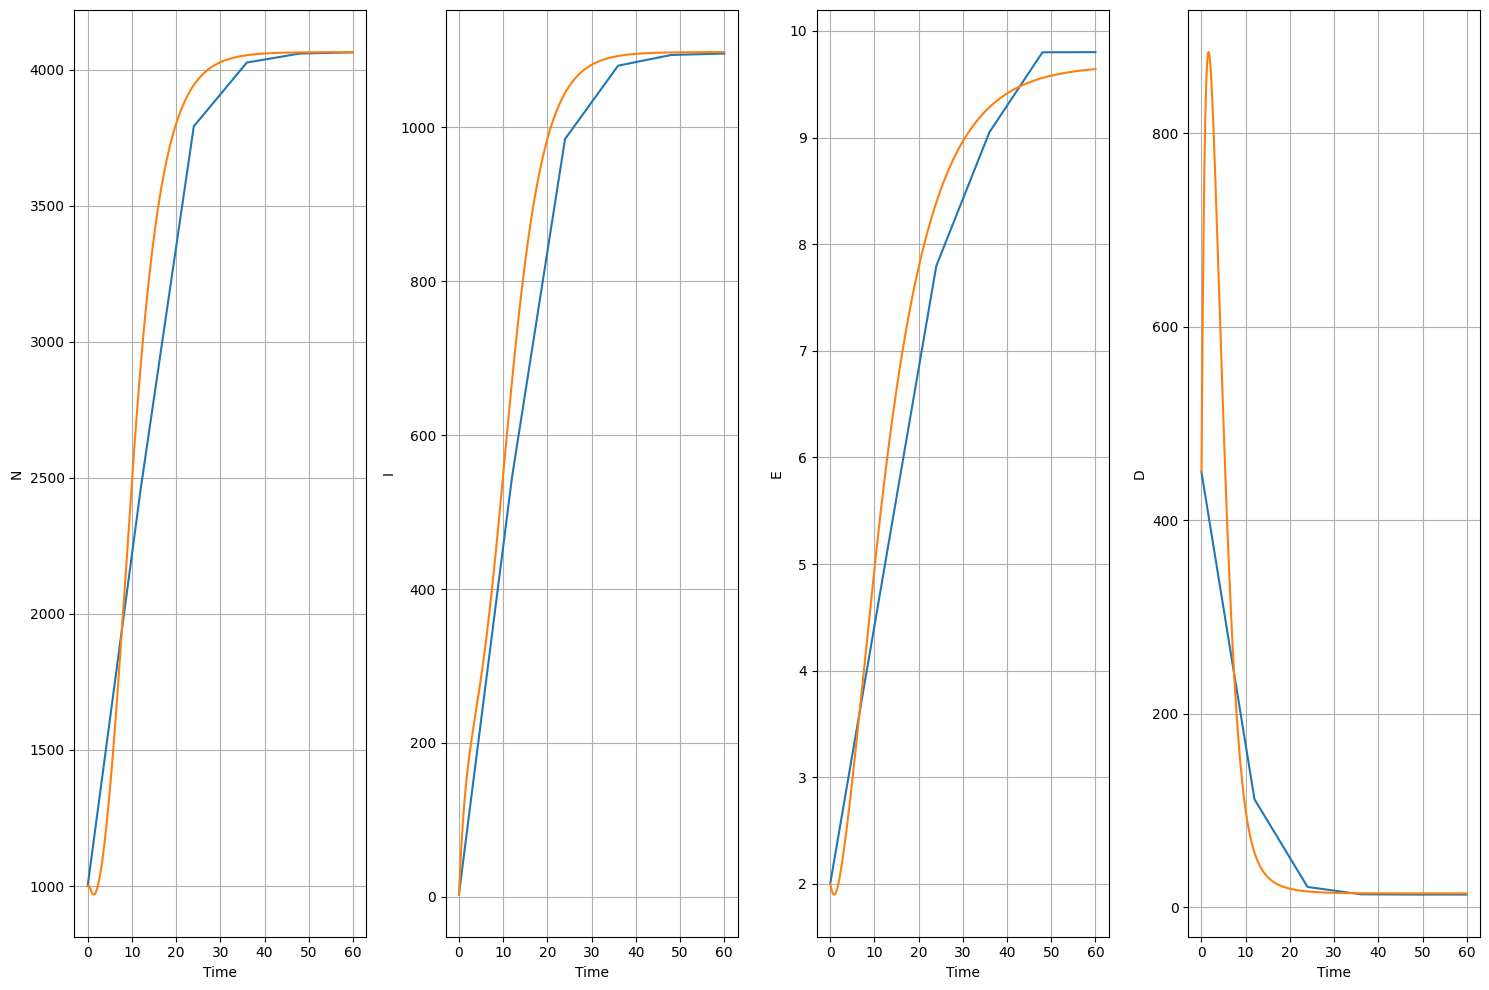

In [ ]:
x1 = np.linspace(0, T*10, num=T)
x2 = np.linspace(0, T*10, num=Test_Data['Real_Time_Series'].shape[1])
#predicted = np.concatenate((prior_sample_test(Initial)[:,2:],x_sim_s),axis=0)
predicted = Test_Data['next_step'][0]
fig, ax = plt.subplots(1, 4, figsize=(15, 10))
ax = ax.flat

for i in range(4):
    ax[i].plot(x1,predicted[i,:], label = "Predicted")
    ax[i].plot(x2,Test_Data['Real_Time_Series'][i], label = "Simulated")
    ax[i].set_xlabel("Time")
    if i == 0:
      ax[i].set_ylabel("N")
    elif i == 1:
      ax[i].set_ylabel("I")
    elif i == 2:
      ax[i].set_ylabel("E")
    elif i == 3:
      ax[i].set_ylabel("D")
    ax[i].grid(True)
    #ax[i].legend()

plt.tight_layout()
plt.show()

# Toy Example

In [ ]:
def prior_sample(Initial, Initial_Params = True):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = np.random.uniform(500,5500)
    D_ext = np.random.uniform(2500,3300)
    if Initial_Params:
      #N_ext = np.random.uniform(500,5500)
      #D_ext = np.random.uniform(2500,3300)
      N_0 = np.random.uniform(380,4500)
      print("N_0 = ", N_0)

      I_0 = np.random.uniform(0,1500)
      print("I_0 = ", I_0)

      E_0 = np.random.uniform(0,10)
      print("E_0 = ", E_0)

      D_0 = np.random.uniform(10,3000)
      print("D_0 = ", D_0)

    else:
      N_0 = Initial[0]
      I_0 = Initial[1]
      E_0 = Initial[2]
      D_0 = Initial[3]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [ ]:
def Setting_Params(Prev_Step_out):
  new_prior = np.zeros((6,Prev_Step_out.shape[1]))
  for i in range(Prev_Step_out.shape[1]):
    if i == 0:
      new_prior[0][i] = Prev_Step_out[0][i+1]
      new_prior[1][i] = Prev_Step_out[3][i+1]
    elif i == Prev_Step_out.shape[1]-1:
      new_prior[0][i] = Prev_Step_out[0][i-1]
      new_prior[1][i] = Prev_Step_out[3][i-1]
    else:
      new_prior[0][i] = 0.5*Prev_Step_out[0][i-1] + 0.5*Prev_Step_out[0][i+1]
      new_prior[1][i] = 0.5*Prev_Step_out[3][i-1] + 0.5*Prev_Step_out[3][i+1]
    #print(new_prior[0])
    #print(new_prior[1])
    new_prior[2][i] = Prev_Step_out[0][i]
    new_prior[3][i] = Prev_Step_out[1][i]
    new_prior[4][i] = Prev_Step_out[2][i]
    new_prior[5][i] = Prev_Step_out[3][i]
  return new_prior

In [ ]:
N_Cells = 10
#Initial_Cells = {}
#Initial_Cells['Prior'] = np.ndarray((0,6))
#inital_conditions = np.zeros((4,))
#for i in range(N_Cells):
#  print("Cell number ", i)
#  prior = prior_sample(inital_conditions)
#  Initial_Cells['Prior'] = np.concatenate((Initial_Cells['Prior'], prior), axis=0)

Initial_Cells ={}
A = np.zeros((10,6))
#Cell number  0
A[0][2] =  1835.1294454248948
A[0][3] =  329.70985181343406
A[0][4] =  9.91481515640452
A[0][5] =  2235.3864692759657
#Cell number  1
A[1][2] =  1275.558664847953
A[1][3] =  593.6565675693729
A[1][4] =  9.363441833518873
A[1][5] =  1125.4568341552365
#Cell number  2
A[2][2] =  2853.422549520553
A[2][3] =  99.36691922468982
A[2][4] =  9.021156118306058
A[2][5] =  219.14507736065477
#Cell number  3
A[3][2] =  498.28026684835845
A[3][3] =  1492.0329168951134
A[3][4] =  0.3508781117439963
A[3][5] =  218.87083599924608
#Cell number  4
A[4][2] =  4440.854907207302
A[4][3] =  1311.865245045852
A[4][4] =  6.944665497484165
A[4][5] =  2724.100337493131
#Cell number  5
A[5][2]=  3529.357777465493
A[5][3] =  865.3996195496832
A[5][4] =  3.1816089300273243
A[5][5] =  967.8782884068388
#Cell number  6
A[6][2] =  4125.005755487573
A[6][3] =  657.6200688380189
A[6][4] =  6.240878607687883
A[6][5] =  2410.4797123670214
#Cell number  7
A[7][2] =  1172.1556474445902
A[7][3] =  870.780363136085
A[7][4] =  4.963713400462191
A[7][5] =  2951.3805392422464
#Cell number  8
A[8][2] =  3152.0123248960526
A[8][3] =  676.3365573041848
A[8][4] =  4.223105920868997
A[8][5] =  482.5191013735446
#Cell number  9
A[9][2] =  1975.866558058985
A[9][3] =  342.02802578614626
A[9][4] =  0.3588372370364801
A[9][5] =  1026.691089760975

Initial_Cells['Prior'] = A

In [ ]:
steps = 50
Changes_In_Time_Pred = np.zeros((10,6,steps))
Changes_In_Time_Sim = np.zeros((10,6,steps))
test_dict = {}
test_dict['training'] = 'False'
Cells = Initial_Cells["Prior"][:,2:]
Cells_sim = Initial_Cells["Prior"][:,2:]

Test = {}
for i in tqdm(range(steps)):
  Cells = np.transpose(Cells)
  Cells_sim = np.transpose(Cells_sim)

  next_step_prior = Setting_Params(Cells)
  Cells = np.transpose(next_step_prior)
  print(Cells.shape)

  next_step_prior = Setting_Params(Cells_sim)
  Cells_sim = np.transpose(next_step_prior)
  print(Cells_sim.shape)

  Changes_In_Time_Pred[:,:,i] = Cells
  Changes_In_Time_Sim[:,:,i] = Cells_sim
  test_x = np.divide(Cells,mX)
  pred = np.divide(model.predict(test_x, verbose = 0),mY)
  #pred[pred == 0] = 0.01
  #pred[pred == 1] = 0.99
  x_pred = pred
  #x_pred_t = np.transpose(x_pred)
  Cells = x_pred

  x_sim = np.zeros((10,4))
  for p in range(N_Cells):
    x_sim[p] = Nonlinear_Solver(Cells_sim[p],10)[:,-1]
  #x_sim_t = np.transpose(x_sim)
  Cells_sim = x_sim

  0%|          | 0/50 [00:00<?, ?it/s]

(10, 6)
(10, 6)


  2%|▏         | 1/50 [00:00<00:18,  2.59it/s]

(10, 6)
(10, 6)


  4%|▍         | 2/50 [00:00<00:20,  2.40it/s]

(10, 6)
(10, 6)


  6%|▌         | 3/50 [00:01<00:22,  2.13it/s]

(10, 6)
(10, 6)


  8%|▊         | 4/50 [00:02<00:24,  1.86it/s]

(10, 6)
(10, 6)


 10%|█         | 5/50 [00:02<00:25,  1.78it/s]

(10, 6)
(10, 6)


 12%|█▏        | 6/50 [00:03<00:25,  1.73it/s]

(10, 6)
(10, 6)


 14%|█▍        | 7/50 [00:03<00:24,  1.72it/s]

(10, 6)
(10, 6)


 16%|█▌        | 8/50 [00:04<00:24,  1.68it/s]

(10, 6)
(10, 6)


 18%|█▊        | 9/50 [00:05<00:24,  1.69it/s]

(10, 6)
(10, 6)


 20%|██        | 10/50 [00:05<00:23,  1.72it/s]

(10, 6)
(10, 6)


 22%|██▏       | 11/50 [00:05<00:19,  1.95it/s]

(10, 6)
(10, 6)


 24%|██▍       | 12/50 [00:06<00:17,  2.16it/s]

(10, 6)
(10, 6)


 26%|██▌       | 13/50 [00:06<00:16,  2.27it/s]

(10, 6)
(10, 6)


 28%|██▊       | 14/50 [00:07<00:15,  2.32it/s]

(10, 6)
(10, 6)


 30%|███       | 15/50 [00:07<00:14,  2.46it/s]

(10, 6)
(10, 6)


 32%|███▏      | 16/50 [00:07<00:13,  2.55it/s]

(10, 6)
(10, 6)


 34%|███▍      | 17/50 [00:08<00:12,  2.64it/s]

(10, 6)
(10, 6)


 36%|███▌      | 18/50 [00:08<00:11,  2.69it/s]

(10, 6)
(10, 6)


 38%|███▊      | 19/50 [00:08<00:11,  2.77it/s]

(10, 6)
(10, 6)


 40%|████      | 20/50 [00:09<00:10,  2.81it/s]

(10, 6)
(10, 6)


 42%|████▏     | 21/50 [00:09<00:09,  2.94it/s]

(10, 6)
(10, 6)


 44%|████▍     | 22/50 [00:09<00:09,  2.88it/s]

(10, 6)
(10, 6)


 46%|████▌     | 23/50 [00:10<00:09,  2.92it/s]

(10, 6)
(10, 6)


 48%|████▊     | 24/50 [00:10<00:08,  2.91it/s]

(10, 6)
(10, 6)


 50%|█████     | 25/50 [00:10<00:08,  2.82it/s]

(10, 6)
(10, 6)


 52%|█████▏    | 26/50 [00:11<00:08,  2.91it/s]

(10, 6)
(10, 6)


 54%|█████▍    | 27/50 [00:11<00:07,  3.02it/s]

(10, 6)
(10, 6)


 56%|█████▌    | 28/50 [00:11<00:07,  2.94it/s]

(10, 6)
(10, 6)


 58%|█████▊    | 29/50 [00:12<00:07,  2.95it/s]

(10, 6)
(10, 6)


 60%|██████    | 30/50 [00:12<00:06,  2.90it/s]

(10, 6)
(10, 6)


 62%|██████▏   | 31/50 [00:12<00:06,  2.84it/s]

(10, 6)
(10, 6)


 64%|██████▍   | 32/50 [00:13<00:06,  2.85it/s]

(10, 6)
(10, 6)


 66%|██████▌   | 33/50 [00:13<00:06,  2.57it/s]

(10, 6)
(10, 6)


 68%|██████▊   | 34/50 [00:14<00:06,  2.32it/s]

(10, 6)
(10, 6)


 70%|███████   | 35/50 [00:14<00:06,  2.50it/s]

(10, 6)
(10, 6)


 72%|███████▏  | 36/50 [00:14<00:05,  2.55it/s]

(10, 6)
(10, 6)


 74%|███████▍  | 37/50 [00:15<00:04,  2.71it/s]

(10, 6)
(10, 6)


 76%|███████▌  | 38/50 [00:15<00:04,  2.70it/s]

(10, 6)
(10, 6)


 78%|███████▊  | 39/50 [00:16<00:04,  2.38it/s]

(10, 6)
(10, 6)


 80%|████████  | 40/50 [00:16<00:04,  2.20it/s]

(10, 6)
(10, 6)


 82%|████████▏ | 41/50 [00:17<00:04,  2.08it/s]

(10, 6)
(10, 6)


 84%|████████▍ | 42/50 [00:17<00:03,  2.05it/s]

(10, 6)
(10, 6)


 86%|████████▌ | 43/50 [00:18<00:03,  2.02it/s]

(10, 6)
(10, 6)


 88%|████████▊ | 44/50 [00:18<00:03,  1.97it/s]

(10, 6)
(10, 6)


 90%|█████████ | 45/50 [00:19<00:02,  1.94it/s]

(10, 6)
(10, 6)


 92%|█████████▏| 46/50 [00:19<00:02,  1.89it/s]

(10, 6)
(10, 6)


 94%|█████████▍| 47/50 [00:20<00:01,  2.09it/s]

(10, 6)
(10, 6)


 96%|█████████▌| 48/50 [00:20<00:00,  2.32it/s]

(10, 6)
(10, 6)


 98%|█████████▊| 49/50 [00:20<00:00,  2.49it/s]

(10, 6)
(10, 6)


100%|██████████| 50/50 [00:21<00:00,  2.35it/s]


# Toy Example with more time between

In [ ]:
def prior_sample(Initial, Initial_Params = True):
    """
    Implements batch sampling from a stationary prior over the parameters
    of the non-stationary SIR model.
    """

    N_ext = np.random.uniform(500,5500)
    D_ext = np.random.uniform(2500,3300)
    if Initial_Params:
      #N_ext = np.random.uniform(500,5500)
      #D_ext = np.random.uniform(2500,3300)
      N_0 = np.random.uniform(380,4500)
      print("N_0 = ", N_0)

      I_0 = np.random.uniform(0,1500)
      print("I_0 = ", I_0)

      E_0 = np.random.uniform(0,10)
      print("E_0 = ", E_0)

      D_0 = np.random.uniform(10,3000)
      print("D_0 = ", D_0)

    else:
      N_0 = Initial[0]
      I_0 = Initial[1]
      E_0 = Initial[2]
      D_0 = Initial[3]
    params = np.array([N_ext, D_ext, N_0, I_0, E_0, D_0])
    params = np.reshape(params,(1,6))
    return np.ceil(params)

In [ ]:
def Setting_Params(Prev_Step_out):
  new_prior = np.zeros((6,Prev_Step_out.shape[1]))
  for i in range(Prev_Step_out.shape[1]):
    if i == 0:
      new_prior[0][i] = Prev_Step_out[0][i+1]
      new_prior[1][i] = Prev_Step_out[3][i+1]
    elif i == Prev_Step_out.shape[1]-1:
      new_prior[0][i] = Prev_Step_out[0][i-1]
      new_prior[1][i] = Prev_Step_out[3][i-1]
    else:
      new_prior[0][i] = 0.5*Prev_Step_out[0][i-1] + 0.5*Prev_Step_out[0][i+1]
      new_prior[1][i] = 0.5*Prev_Step_out[3][i-1] + 0.5*Prev_Step_out[3][i+1]
    #print(new_prior[0])
    #print(new_prior[1])
    new_prior[2][i] = Prev_Step_out[0][i]
    new_prior[3][i] = Prev_Step_out[1][i]
    new_prior[4][i] = Prev_Step_out[2][i]
    new_prior[5][i] = Prev_Step_out[3][i]
  return new_prior

In [ ]:
N_Cells = 10
Initial_Cells = {}
Initial_Cells['Prior'] = np.ndarray((0,6))
inital_conditions = np.zeros((4,))
for i in range(N_Cells):
  print("Cell number ", i)
  prior = prior_sample(inital_conditions)
  Initial_Cells['Prior'] = np.concatenate((Initial_Cells['Prior'], prior), axis=0)


Cell number  0
N_0 =  1135.193583403654
I_0 =  342.26377158556056
E_0 =  2.6193150819559197
D_0 =  398.09880431336074
Cell number  1
N_0 =  3958.9767721529706
I_0 =  848.379518497696
E_0 =  4.490003692427638
D_0 =  108.70009719957768
Cell number  2
N_0 =  2052.1247389088035
I_0 =  479.4625969625226
E_0 =  4.868759617089266
D_0 =  1069.3266494899797
Cell number  3
N_0 =  3729.953357451634
I_0 =  312.94104689501364
E_0 =  9.160608903470731
D_0 =  524.178468975582
Cell number  4
N_0 =  1750.265158672934
I_0 =  1192.13866178838
E_0 =  8.666922324041552
D_0 =  946.4456735150574
Cell number  5
N_0 =  2355.473921640324
I_0 =  707.2777437958965
E_0 =  4.056475717439264
D_0 =  1937.5770900355515
Cell number  6
N_0 =  3142.5564854614295
I_0 =  178.91098469499673
E_0 =  2.508567818901506
D_0 =  1282.3077173520246
Cell number  7
N_0 =  3758.909605673715
I_0 =  621.8898553114993
E_0 =  3.3541584847127695
D_0 =  2719.7257284055686
Cell number  8
N_0 =  1522.9997940723388
I_0 =  1114.4877530714236
E_

In [ ]:
Initial_Cells['Prior'].shape

(10, 6)

In [ ]:
steps = 50
Changes_In_Time_Pred = np.zeros((10,6,steps))
Changes_In_Time_Sim = np.zeros((10,6,steps))
test_dict = {}
test_dict['training'] = 'False'
Cells = Initial_Cells["Prior"][:,2:]
Cells_sim = Initial_Cells["Prior"][:,2:]

Test = {}
for i in tqdm(range(steps)):
  Cells = np.transpose(Cells)
  Cells_sim = np.transpose(Cells_sim)

  next_step_prior = Setting_Params(Cells)
  Cells = np.transpose(next_step_prior)
  print(Cells.shape)

  next_step_prior = Setting_Params(Cells_sim)
  Cells_sim = np.transpose(next_step_prior)
  print(Cells_sim.shape)

  Changes_In_Time_Pred[:,:,i] = Cells
  Changes_In_Time_Sim[:,:,i] = Cells_sim

  Cells[:,:2] = Changes_In_Time_Pred[:,:2,i//5]
  Cells_sim[:,:2] = Changes_In_Time_Sim[:,:2,i//5]
  test_x = np.divide(Cells,mX)
  pred = model.predict(test_x, verbose = 0)
  pred[pred == 0] = 0.01
  pred[pred == 1] = 0.99
  x_pred = (pred)*(mY)
  #x_pred_t = np.transpose(x_pred)
  Cells = x_pred

  x_sim = np.zeros((10,4))
  for p in range(N_Cells):
    x_sim[p] = Nonlinear_Solver(Cells_sim[p],10)[:,-1]
  #x_sim_t = np.transpose(x_sim)
  Cells_sim = x_sim

  0%|          | 0/50 [00:00<?, ?it/s]

(10, 6)
(10, 6)


  2%|▏         | 1/50 [00:00<00:19,  2.48it/s]

(10, 6)
(10, 6)


  4%|▍         | 2/50 [00:00<00:19,  2.40it/s]

(10, 6)
(10, 6)


  6%|▌         | 3/50 [00:01<00:20,  2.34it/s]

(10, 6)
(10, 6)


  8%|▊         | 4/50 [00:01<00:18,  2.44it/s]

(10, 6)
(10, 6)


 10%|█         | 5/50 [00:02<00:18,  2.41it/s]

(10, 6)
(10, 6)


 12%|█▏        | 6/50 [00:02<00:18,  2.42it/s]

(10, 6)
(10, 6)


 14%|█▍        | 7/50 [00:02<00:17,  2.46it/s]

(10, 6)
(10, 6)


 16%|█▌        | 8/50 [00:03<00:16,  2.55it/s]

(10, 6)
(10, 6)


 18%|█▊        | 9/50 [00:03<00:15,  2.65it/s]

(10, 6)
(10, 6)


 20%|██        | 10/50 [00:03<00:14,  2.73it/s]

(10, 6)
(10, 6)


 22%|██▏       | 11/50 [00:04<00:15,  2.56it/s]

(10, 6)
(10, 6)


 24%|██▍       | 12/50 [00:04<00:15,  2.53it/s]

(10, 6)
(10, 6)


 26%|██▌       | 13/50 [00:05<00:14,  2.60it/s]

(10, 6)
(10, 6)


 28%|██▊       | 14/50 [00:05<00:13,  2.58it/s]

(10, 6)
(10, 6)


 30%|███       | 15/50 [00:05<00:13,  2.50it/s]

(10, 6)
(10, 6)


 32%|███▏      | 16/50 [00:06<00:13,  2.50it/s]

(10, 6)
(10, 6)


 34%|███▍      | 17/50 [00:06<00:14,  2.34it/s]

(10, 6)
(10, 6)


 36%|███▌      | 18/50 [00:07<00:16,  1.98it/s]

(10, 6)
(10, 6)


 38%|███▊      | 19/50 [00:08<00:17,  1.79it/s]

(10, 6)
(10, 6)


 40%|████      | 20/50 [00:08<00:17,  1.68it/s]

(10, 6)
(10, 6)


 42%|████▏     | 21/50 [00:09<00:17,  1.66it/s]

(10, 6)
(10, 6)


 44%|████▍     | 22/50 [00:10<00:17,  1.63it/s]

(10, 6)
(10, 6)


 46%|████▌     | 23/50 [00:10<00:16,  1.59it/s]

(10, 6)
(10, 6)


 48%|████▊     | 24/50 [00:11<00:15,  1.71it/s]

(10, 6)
(10, 6)


 50%|█████     | 25/50 [00:11<00:13,  1.85it/s]

(10, 6)
(10, 6)


 52%|█████▏    | 26/50 [00:12<00:11,  2.00it/s]

(10, 6)
(10, 6)


 54%|█████▍    | 27/50 [00:12<00:10,  2.14it/s]

(10, 6)
(10, 6)


 56%|█████▌    | 28/50 [00:12<00:10,  2.16it/s]

(10, 6)
(10, 6)


 58%|█████▊    | 29/50 [00:13<00:09,  2.18it/s]

(10, 6)
(10, 6)


 60%|██████    | 30/50 [00:13<00:08,  2.23it/s]

(10, 6)
(10, 6)


 62%|██████▏   | 31/50 [00:14<00:08,  2.28it/s]

(10, 6)
(10, 6)


 64%|██████▍   | 32/50 [00:14<00:07,  2.37it/s]

(10, 6)
(10, 6)


 66%|██████▌   | 33/50 [00:15<00:07,  2.33it/s]

(10, 6)
(10, 6)


 68%|██████▊   | 34/50 [00:15<00:06,  2.32it/s]

(10, 6)
(10, 6)


 70%|███████   | 35/50 [00:15<00:06,  2.41it/s]

(10, 6)
(10, 6)


 72%|███████▏  | 36/50 [00:16<00:05,  2.39it/s]

(10, 6)
(10, 6)


 74%|███████▍  | 37/50 [00:16<00:05,  2.42it/s]

(10, 6)
(10, 6)


 76%|███████▌  | 38/50 [00:17<00:05,  2.36it/s]

(10, 6)
(10, 6)


 78%|███████▊  | 39/50 [00:17<00:04,  2.26it/s]

(10, 6)
(10, 6)


 80%|████████  | 40/50 [00:18<00:04,  2.32it/s]

(10, 6)
(10, 6)


 82%|████████▏ | 41/50 [00:18<00:03,  2.40it/s]

(10, 6)
(10, 6)


 84%|████████▍ | 42/50 [00:18<00:03,  2.44it/s]

(10, 6)
(10, 6)


 86%|████████▌ | 43/50 [00:19<00:02,  2.36it/s]

(10, 6)
(10, 6)


 88%|████████▊ | 44/50 [00:19<00:02,  2.38it/s]

(10, 6)
(10, 6)


 90%|█████████ | 45/50 [00:20<00:02,  2.42it/s]

(10, 6)
(10, 6)


 92%|█████████▏| 46/50 [00:20<00:01,  2.47it/s]

(10, 6)
(10, 6)


 94%|█████████▍| 47/50 [00:20<00:01,  2.49it/s]

(10, 6)
(10, 6)


 96%|█████████▌| 48/50 [00:21<00:00,  2.23it/s]

(10, 6)
(10, 6)


 98%|█████████▊| 49/50 [00:22<00:00,  1.99it/s]

(10, 6)
(10, 6)


100%|██████████| 50/50 [00:22<00:00,  2.20it/s]


# Plots for toy example_1


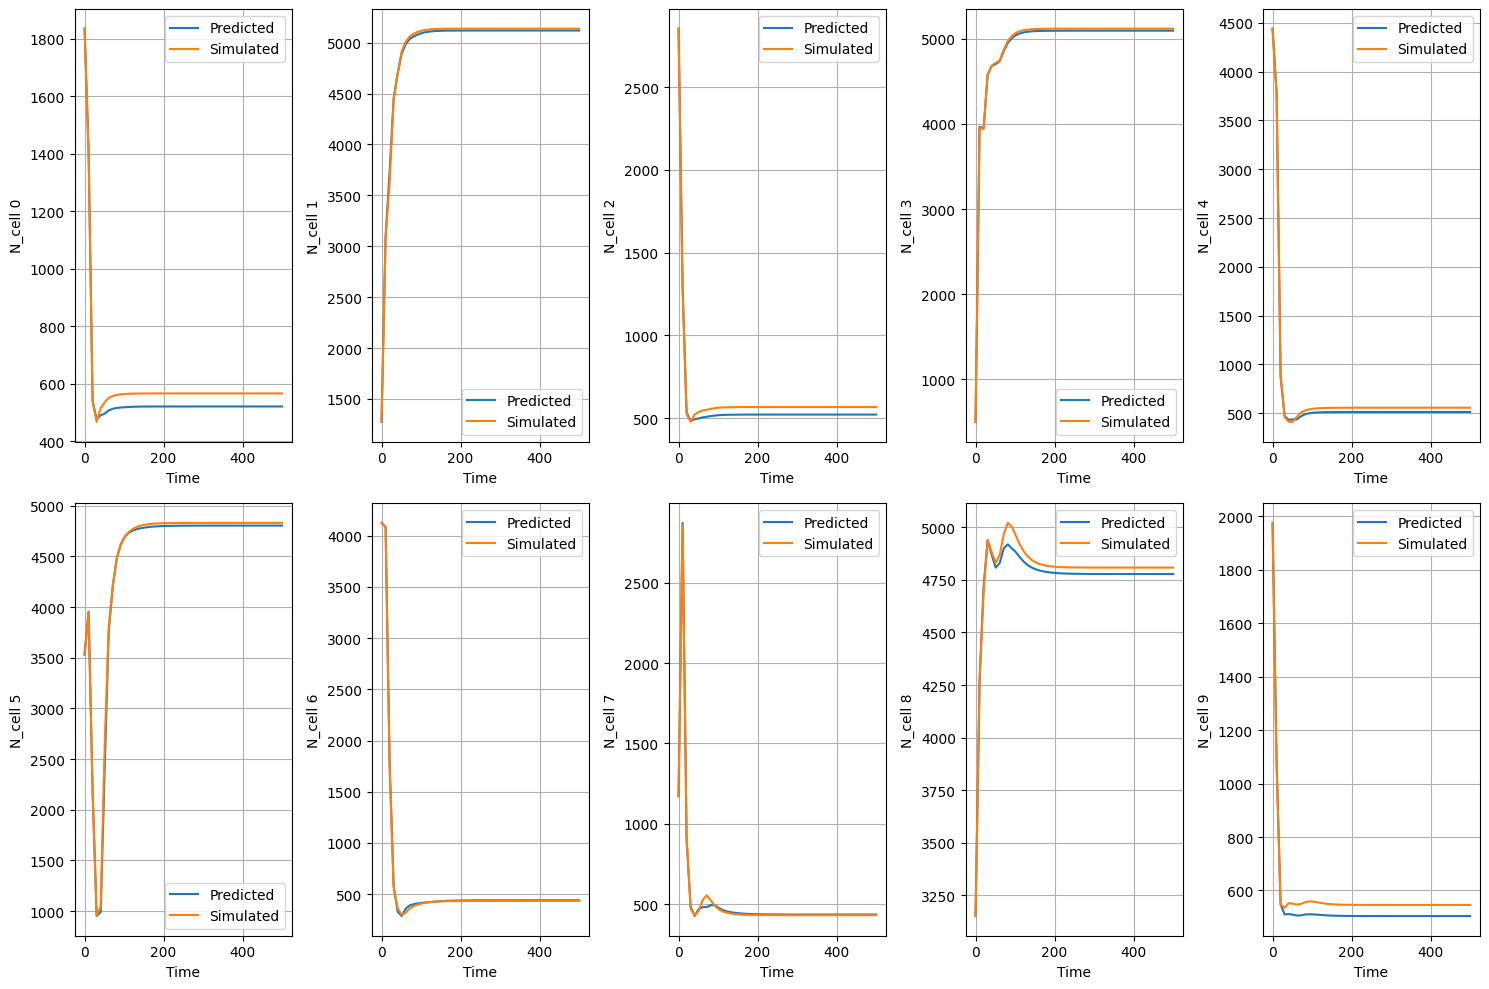

In [ ]:
#Plots for N

x1 = np.linspace(0, steps*10, num=steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][2] , label = "Predicted")
    ax[i].plot(x1,sim[i][2], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"N_cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

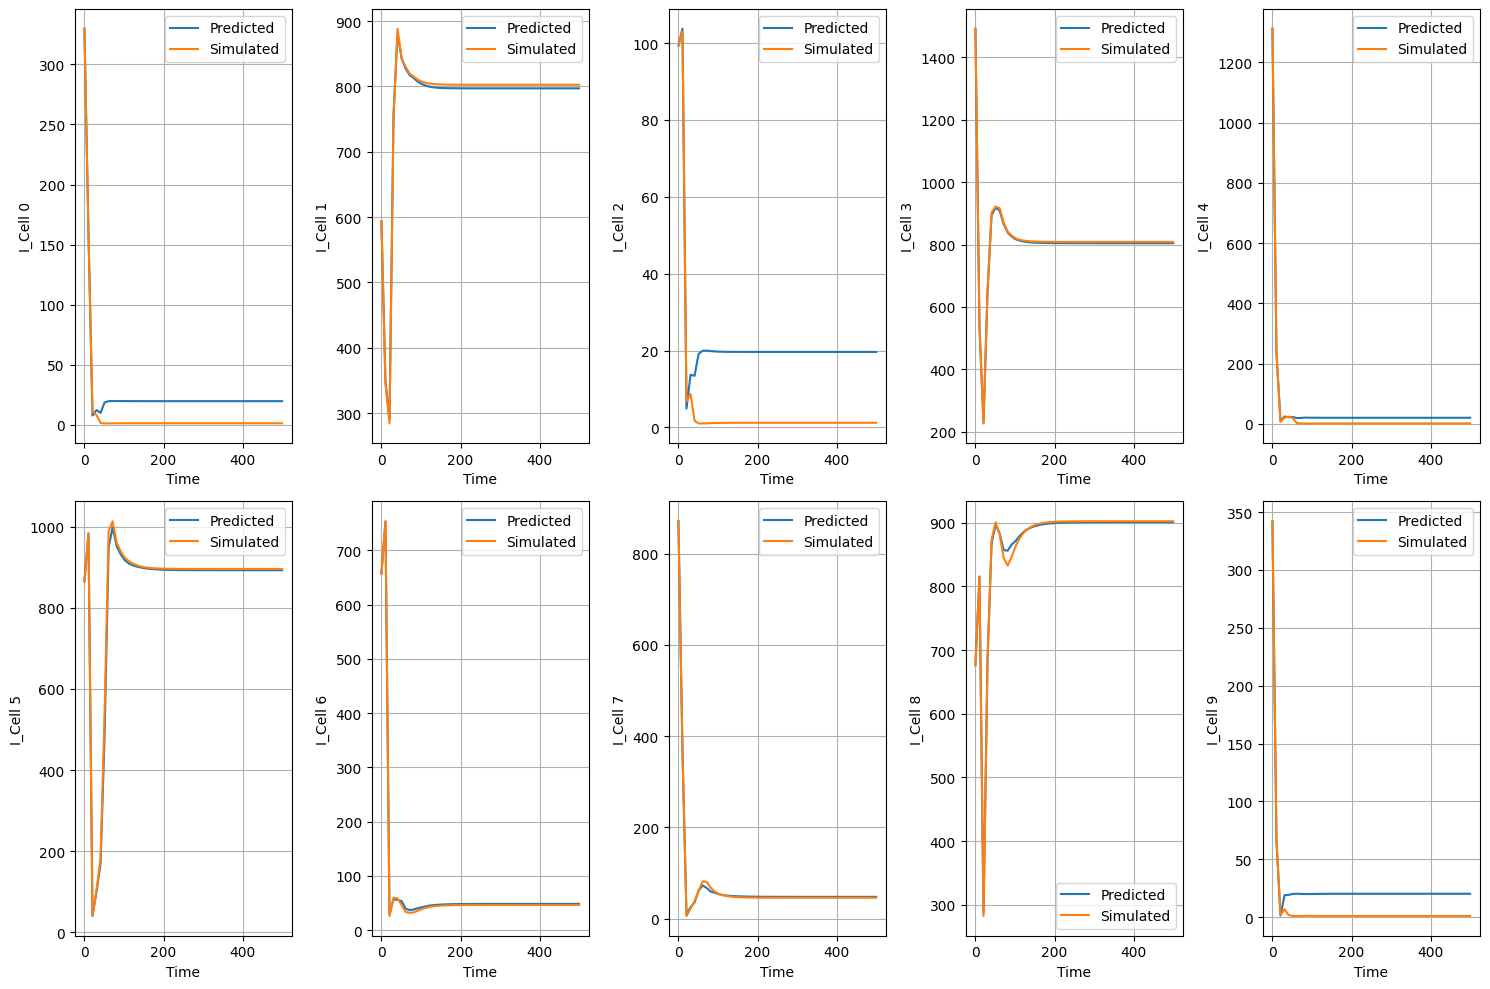

In [ ]:
#Plots for I

x1 = np.linspace(0, steps*10, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][3] , label = "Predicted")
    ax[i].plot(x1,sim[i][3], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"I_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

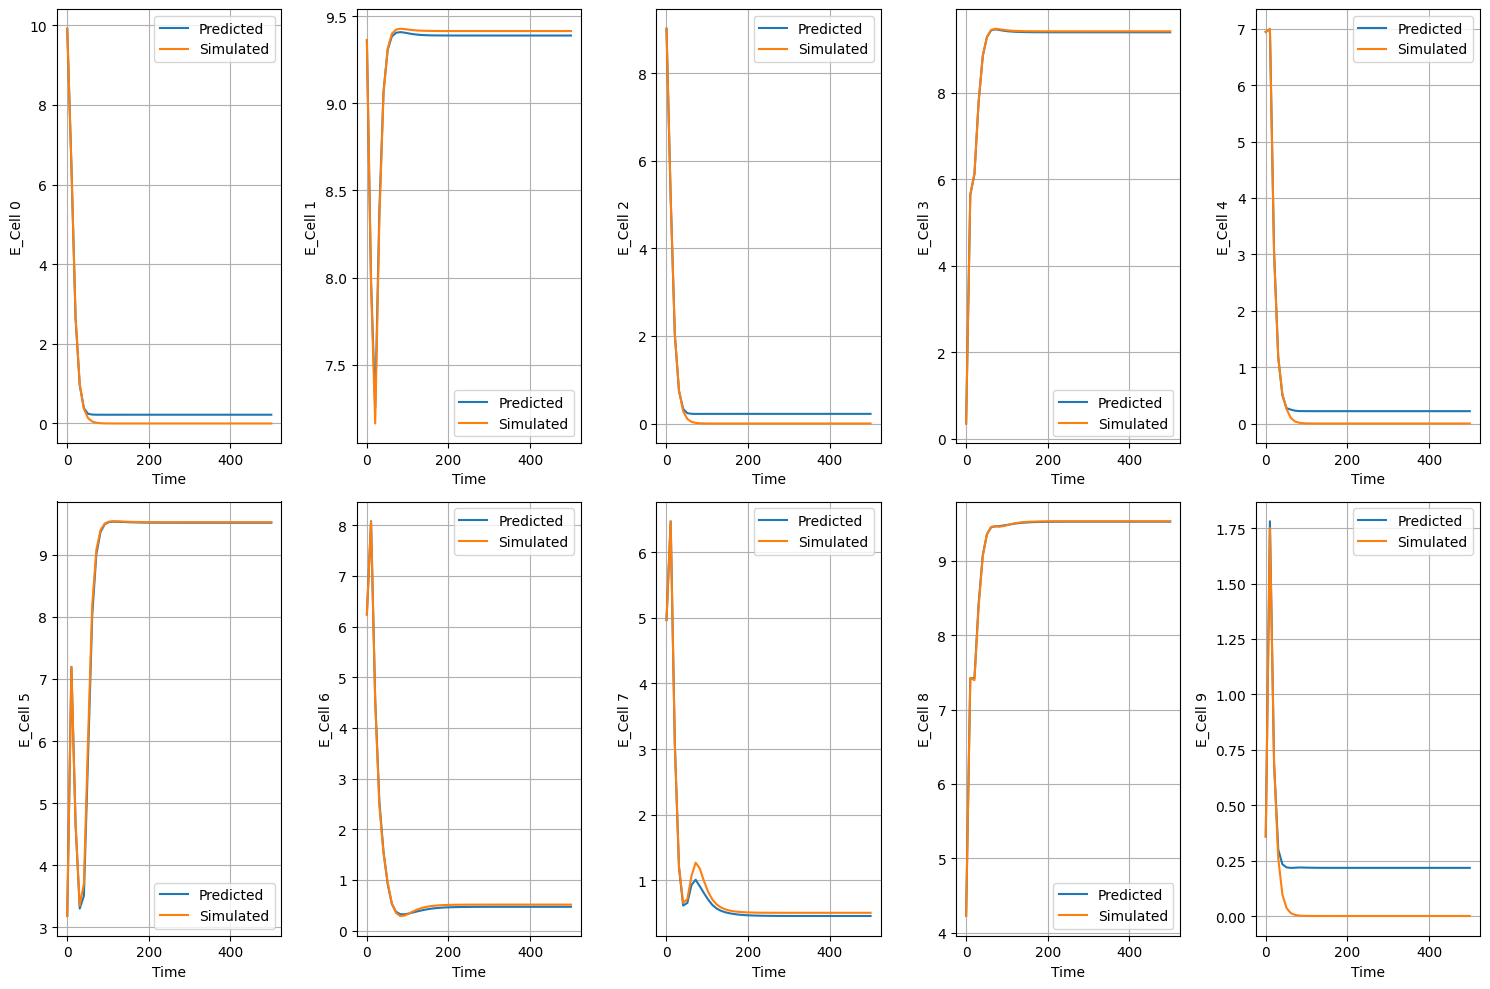

In [ ]:
#Plots for E

x1 = np.linspace(0, steps*10, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][4] , label = "Predicted")
    ax[i].plot(x1,sim[i][4], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"E_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

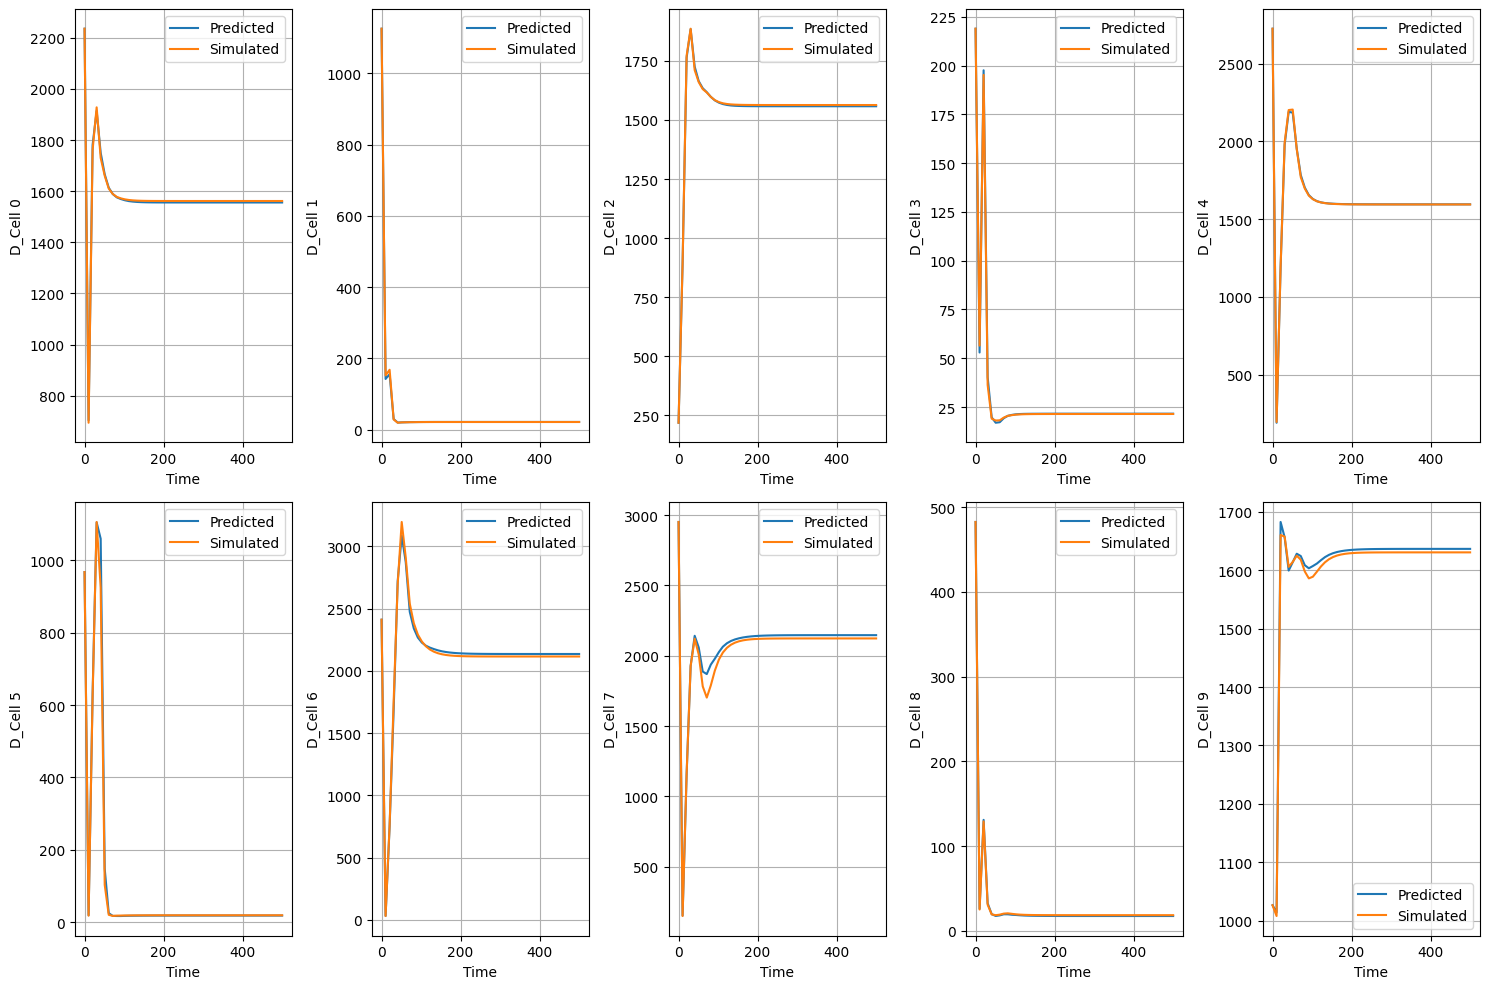

In [ ]:
#Plots for D

x1 = np.linspace(0, steps*10, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][5] , label = "Predicted")
    ax[i].plot(x1,sim[i][5], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"D_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

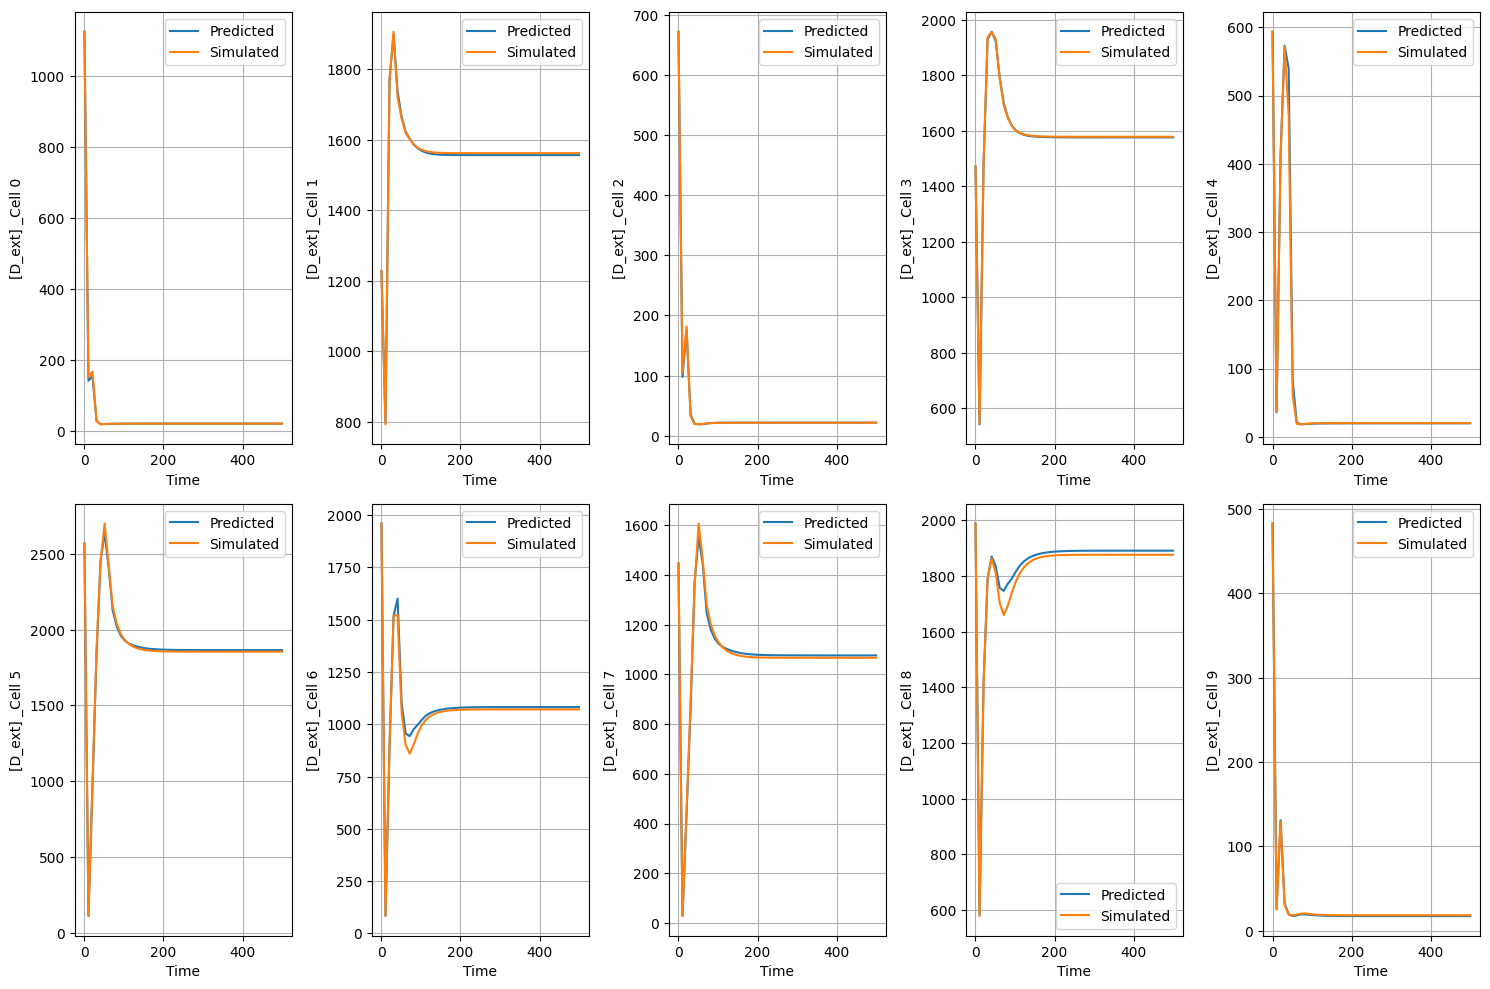

In [ ]:
#Plots for D_ext

x1 = np.linspace(0, steps*10, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][1] , label = "Predicted")
    ax[i].plot(x1,sim[i][1] , label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"[D_ext] _Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

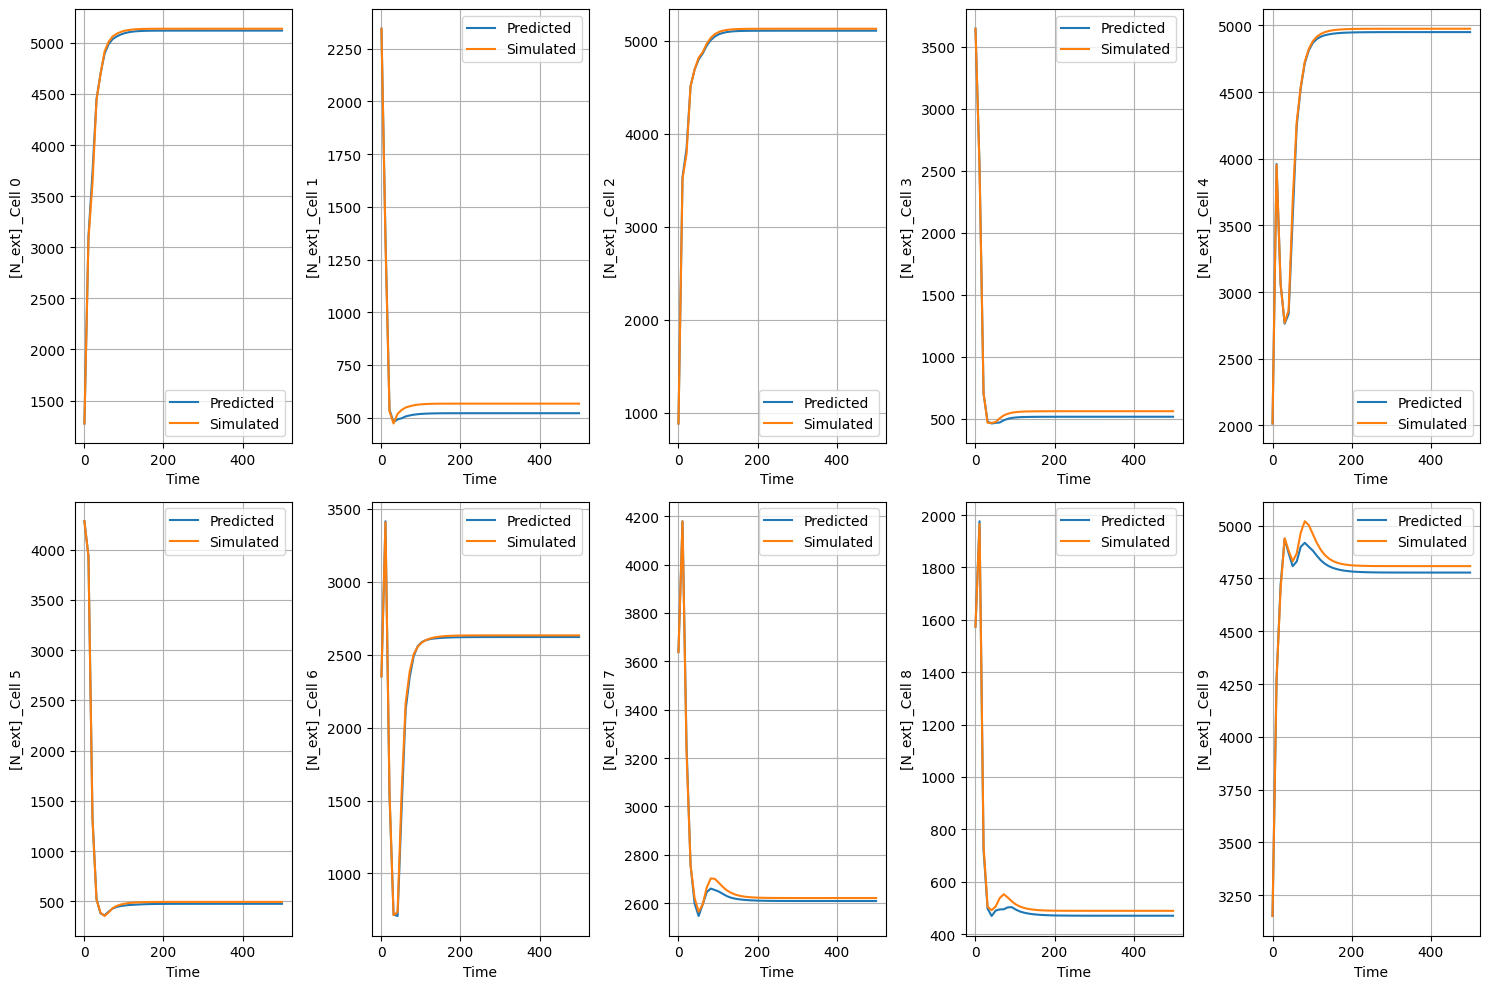

In [ ]:
#Plots for N_ext

x1 = np.linspace(0, steps*10, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][0] , label = "Predicted")
    ax[i].plot(x1,sim[i][0] , label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"[N_ext] _Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

# Plots for toy example_2


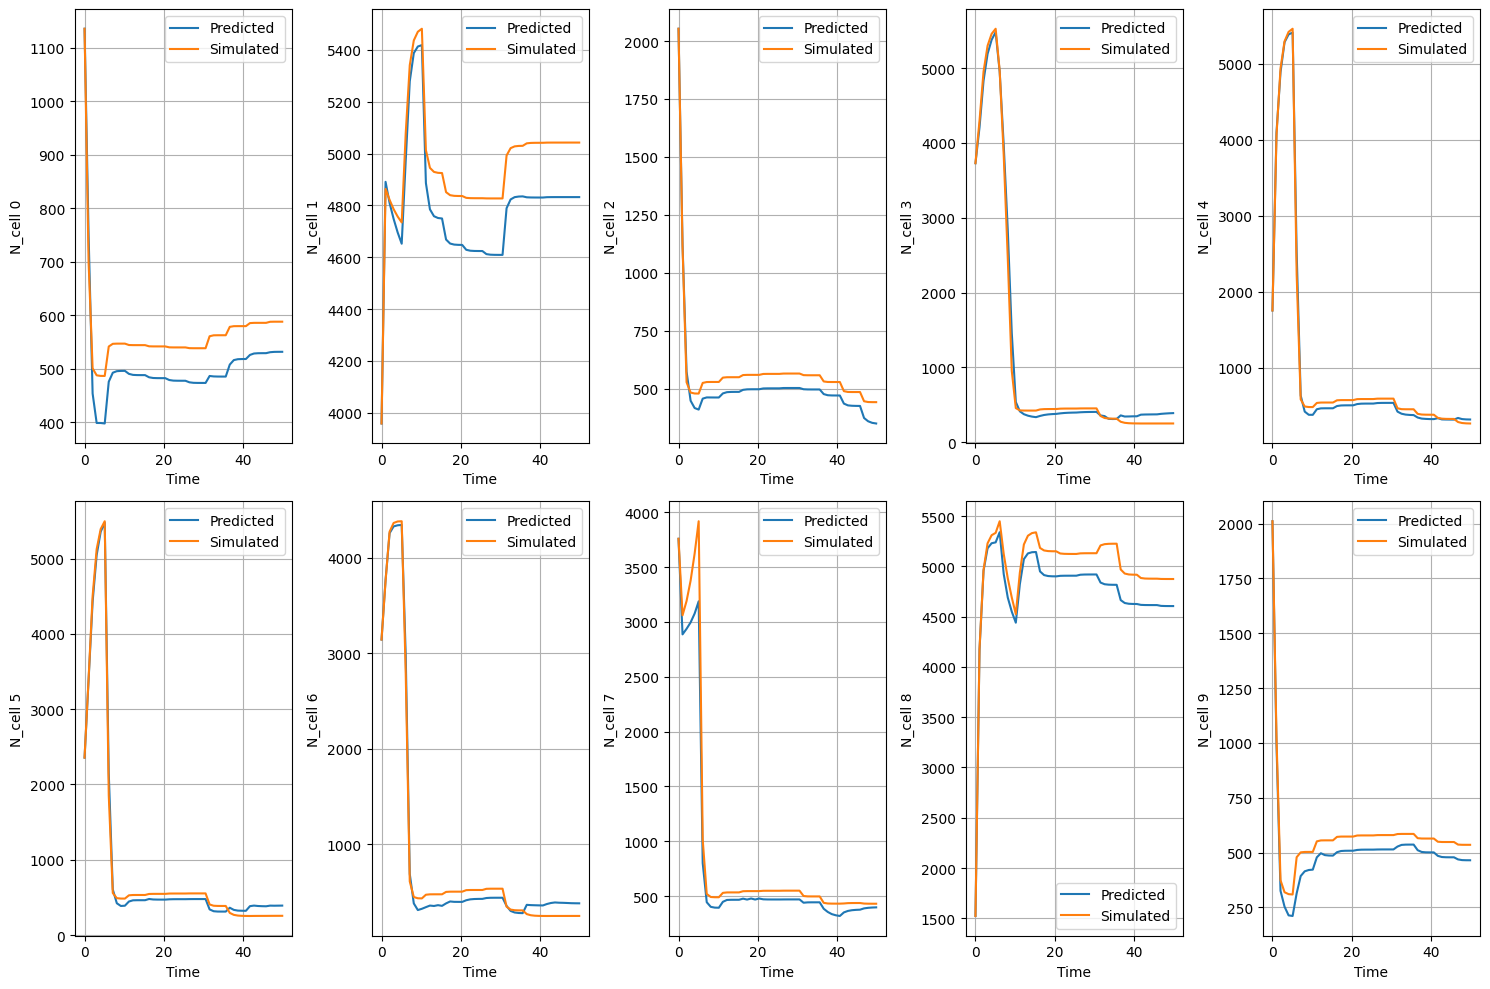

In [ ]:
#Plots for N

x1 = np.linspace(0, steps, num=steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][2] , label = "Predicted")
    ax[i].plot(x1,sim[i][2], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"N_cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

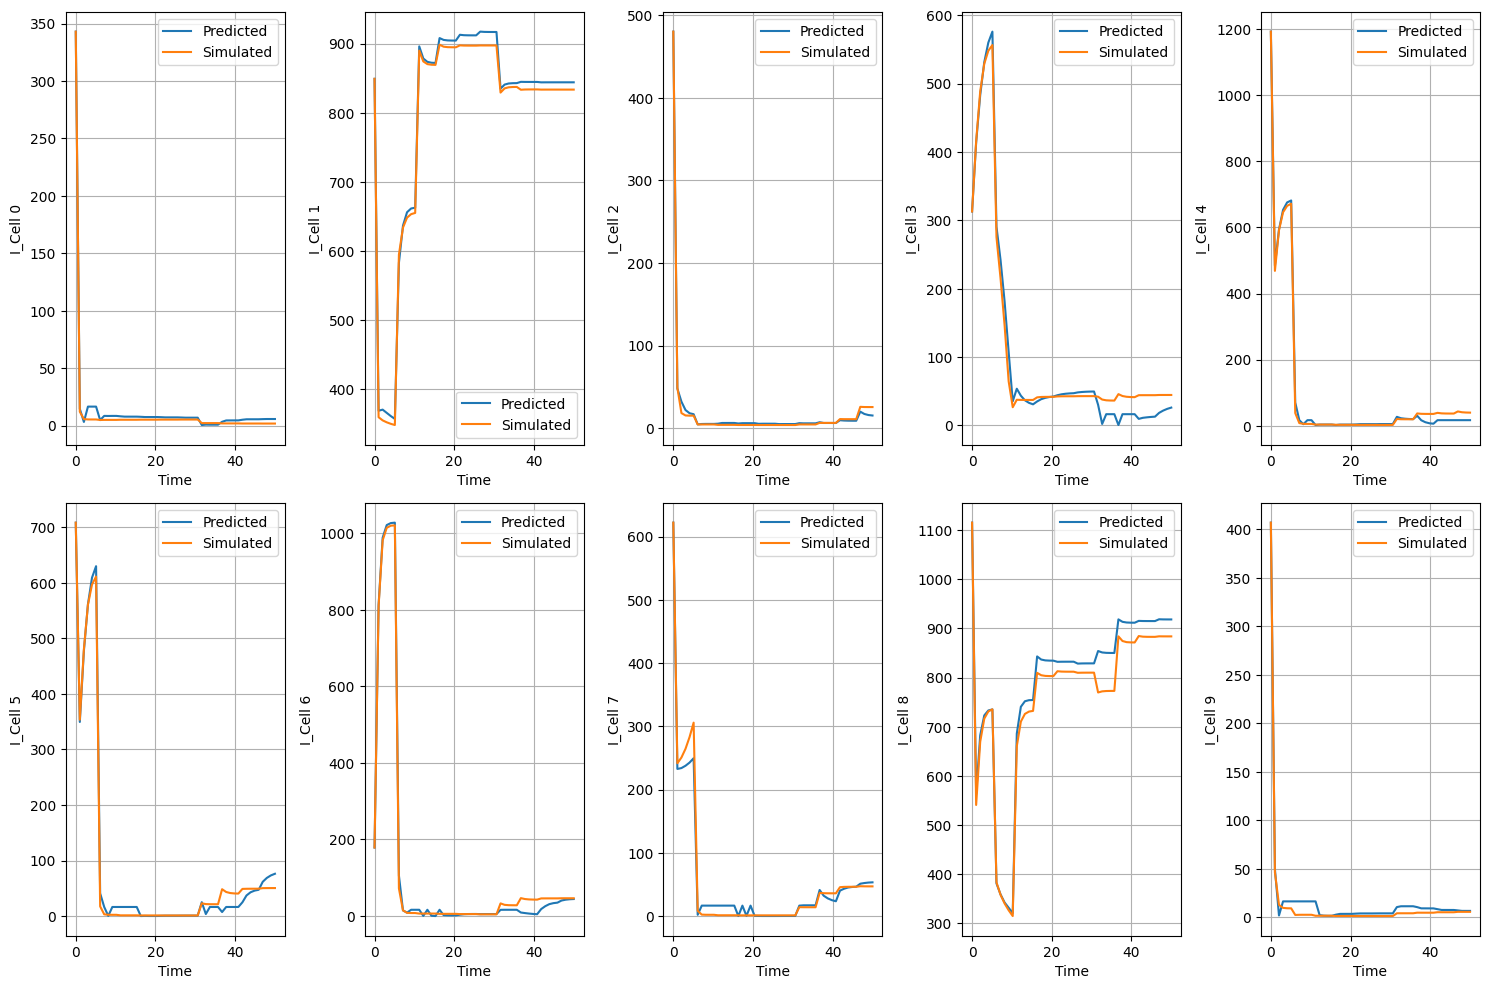

In [ ]:
#Plots for I

x1 = np.linspace(0, steps, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][3] , label = "Predicted")
    ax[i].plot(x1,sim[i][3], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"I_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

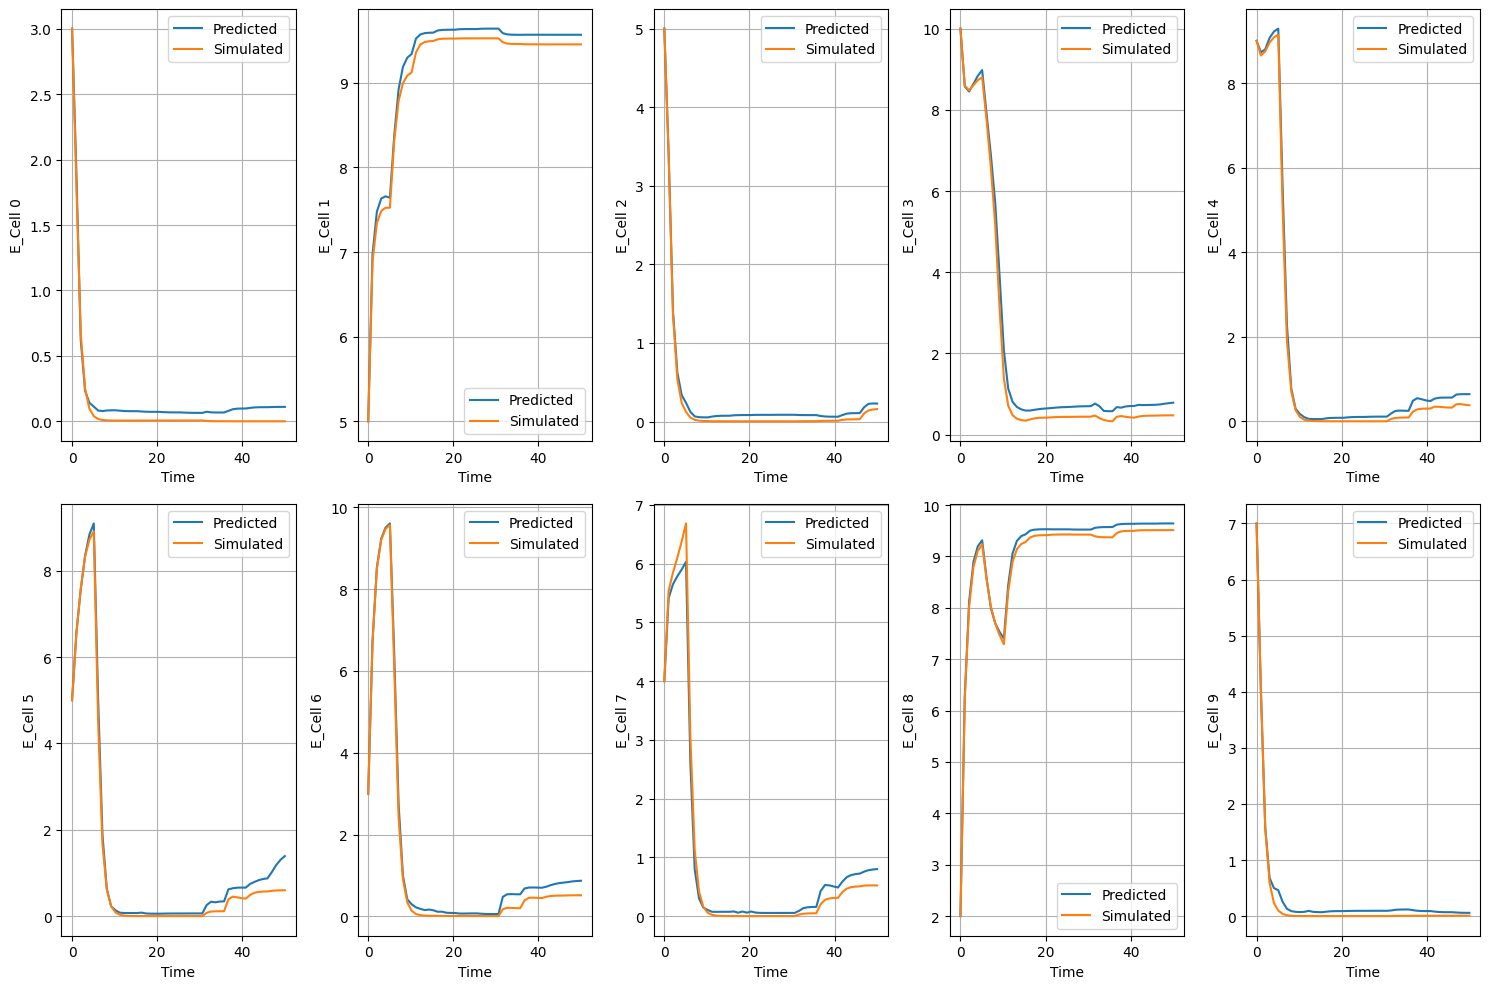

In [ ]:
#Plots for E

x1 = np.linspace(0, steps, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][4] , label = "Predicted")
    ax[i].plot(x1,sim[i][4], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"E_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

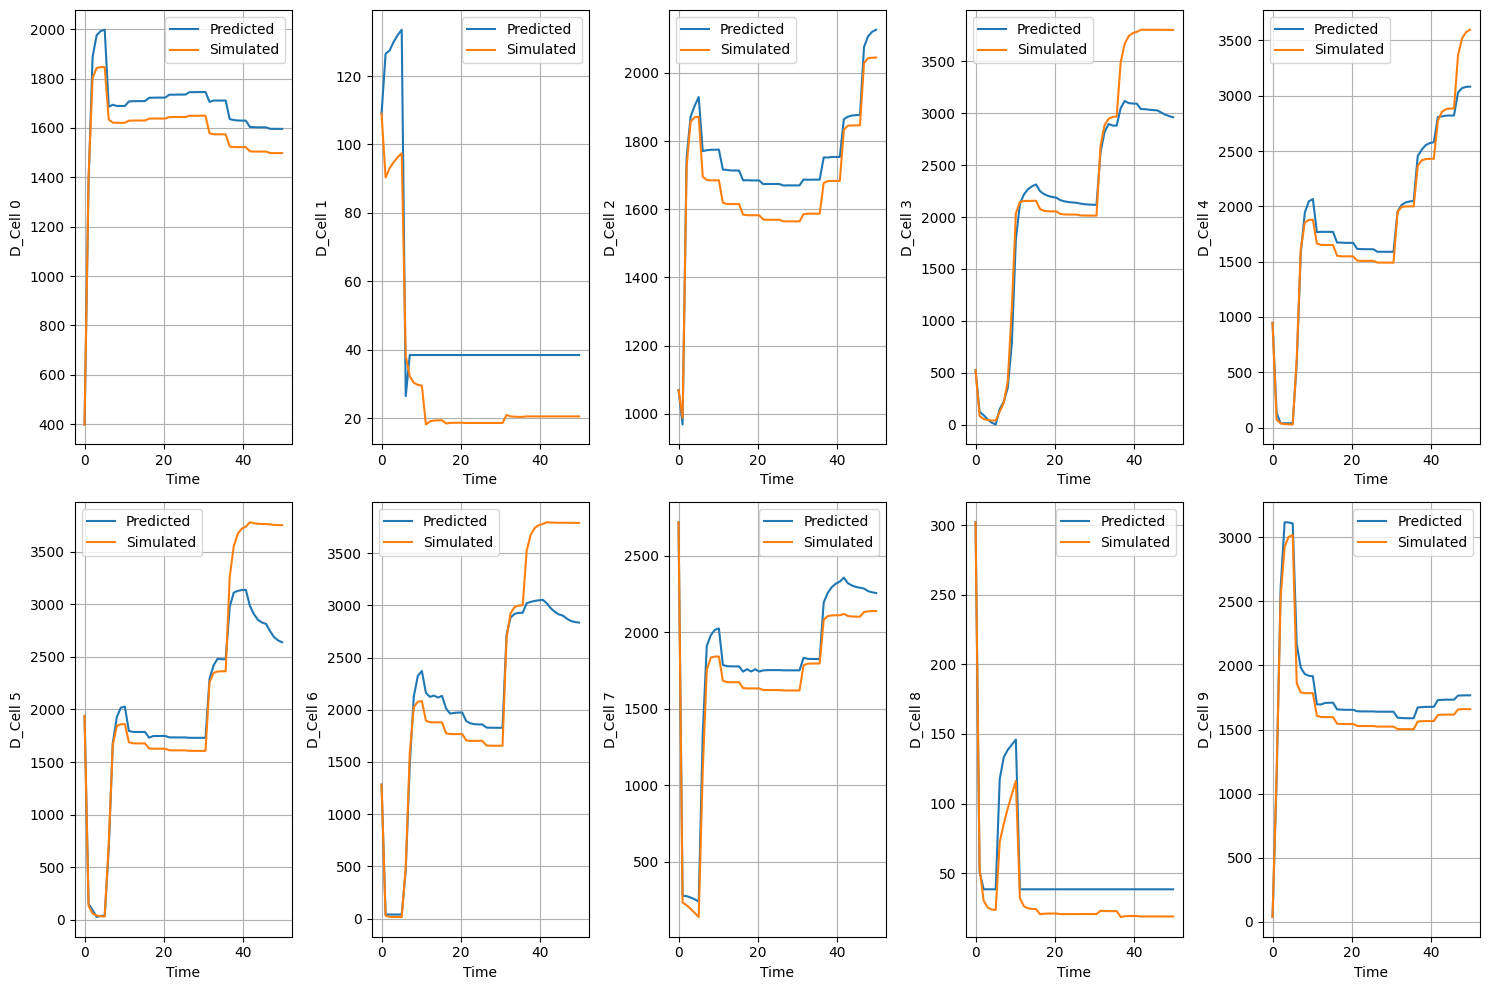

In [ ]:
#Plots for D

x1 = np.linspace(0, steps, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][5] , label = "Predicted")
    ax[i].plot(x1,sim[i][5], label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"D_Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

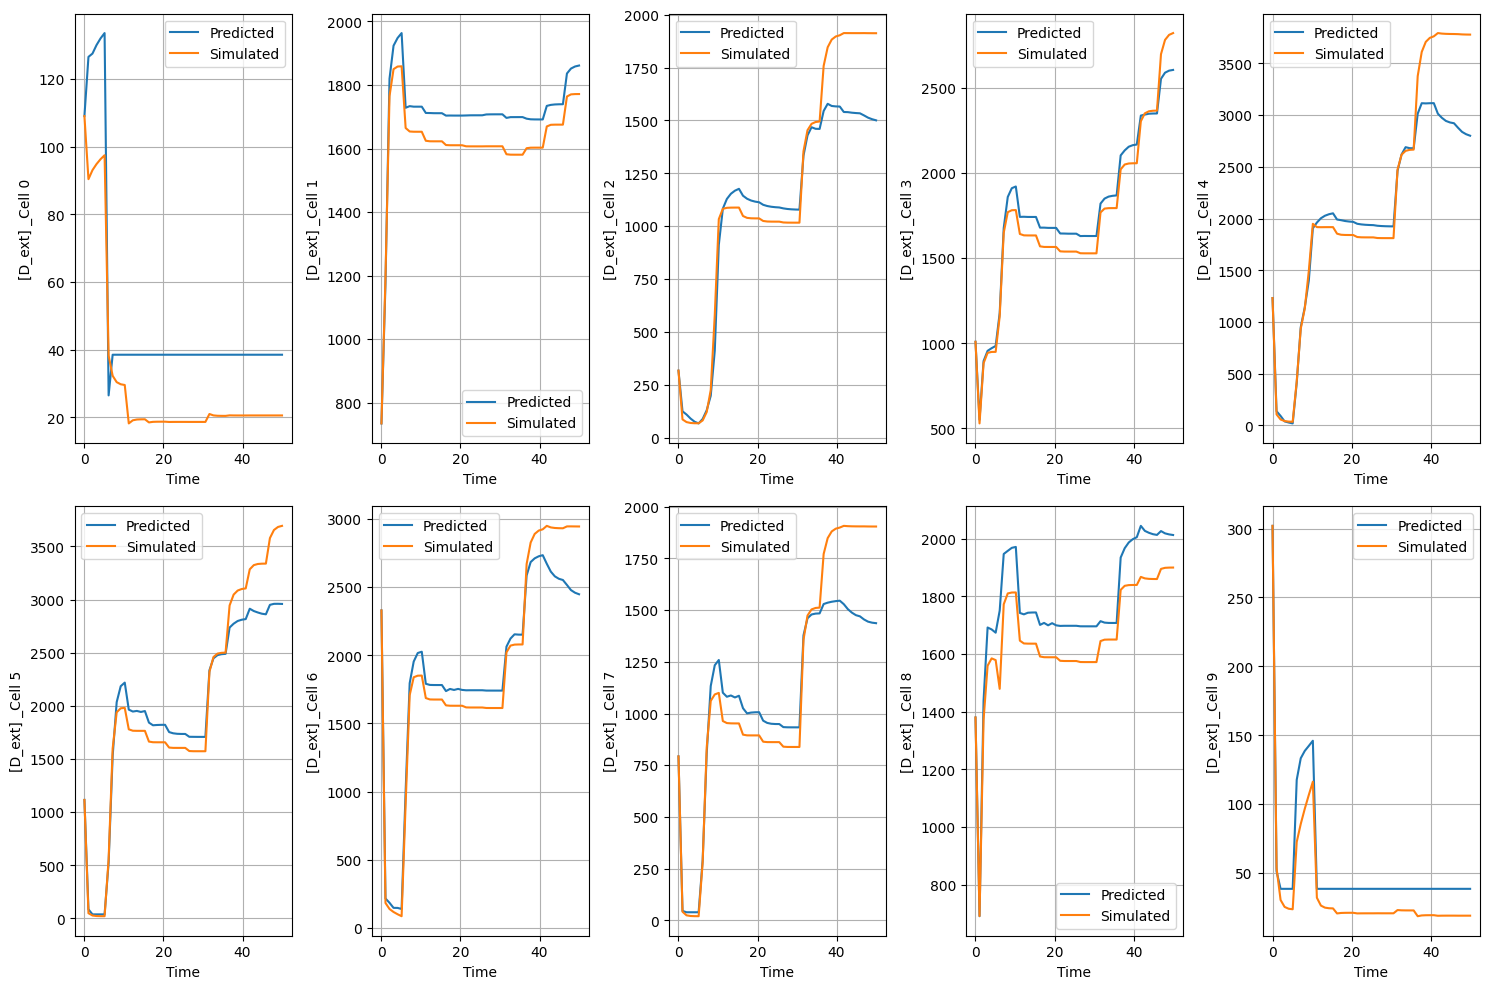

In [ ]:
#Plots for D_ext

x1 = np.linspace(0, steps, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][1] , label = "Predicted")
    ax[i].plot(x1,sim[i][1] , label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"[D_ext] _Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

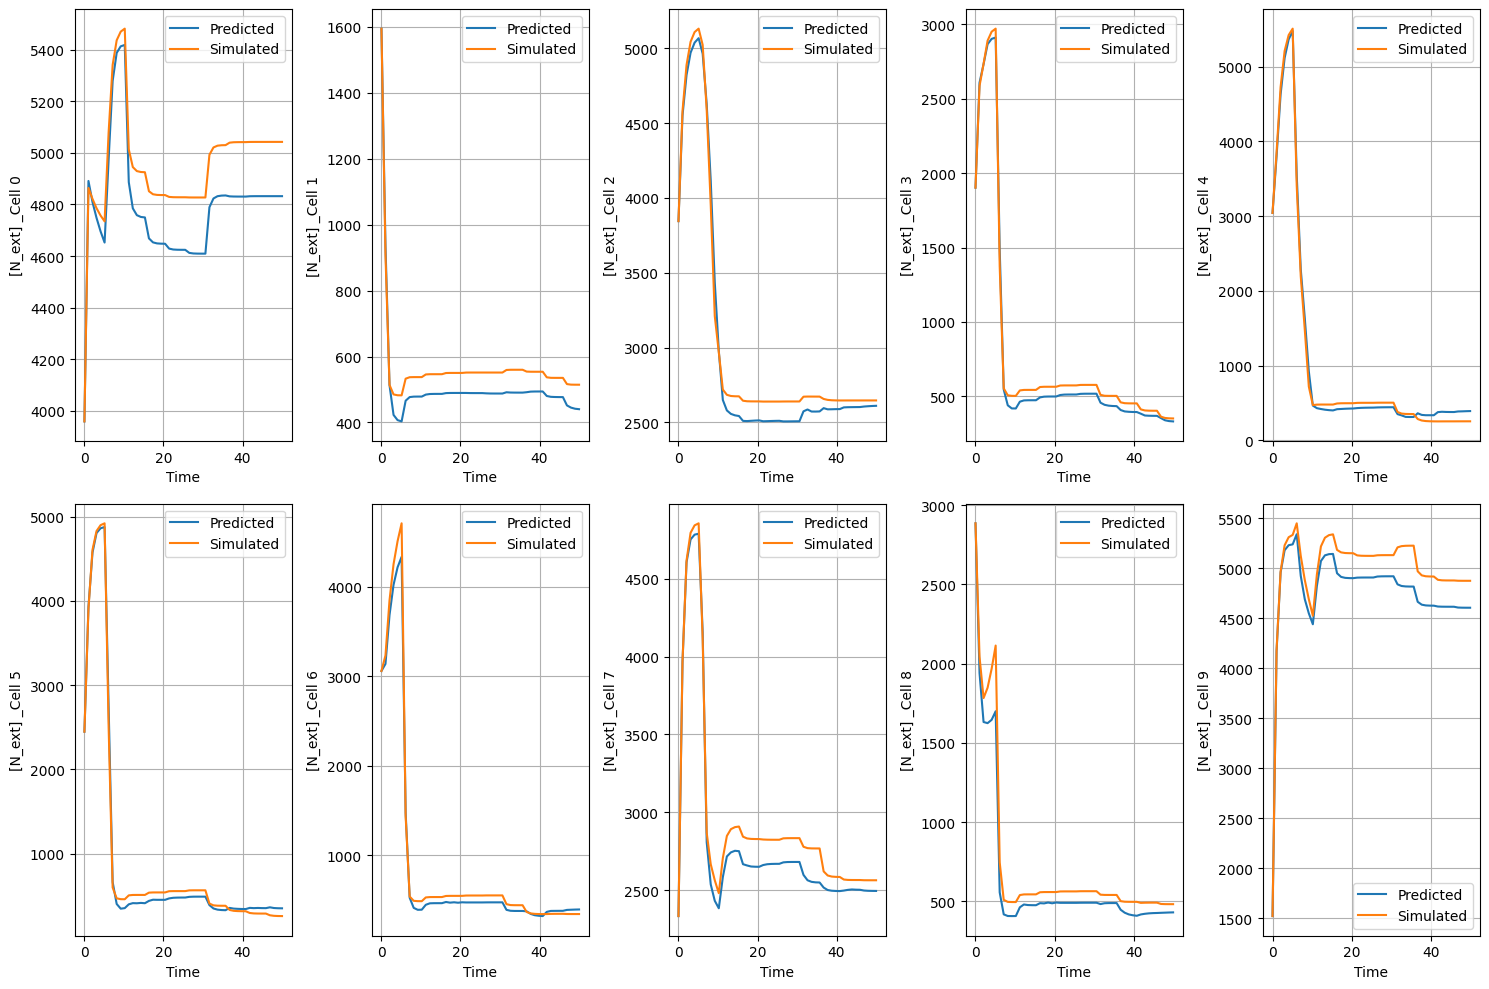

In [ ]:
#Plots for N_ext

x1 = np.linspace(0, steps, num = steps)
#x2 = np.linspace(0, 1, num=32003)
predicted = Changes_In_Time_Pred[:,:,:]
sim = Changes_In_Time_Sim[:,:,:]
fig, ax = plt.subplots(2, 5, figsize=(15, 10))
ax = ax.flat

for i in range(10):
    #ax[i].plot(x1,predicted[i][0])
    ax[i].plot(x1,predicted[i][0] , label = "Predicted")
    ax[i].plot(x1,sim[i][0] , label = "Simulated")
    #ax[i].plot(x1,np.divide(predicted[i][1],predicted[i][5]))
    #ax[i].plot(x1,predicted[i][3])
    ax[i].set_xlabel("Time")
    ax[i].set_ylabel(f"[N_ext] _Cell {i}")
    ax[i].grid(True)
    ax[i].legend()

plt.tight_layout()
plt.show()

# Accuracy and Complexity

In [14]:
# Read dictionary pkl file
with open('/content/drive/MyDrive/Team_Project/Simulated_Data/Training_Test_Sets/One_Step_Simulated_Data_Dist_Test.pkl', 'rb') as fp:
    data = pickle.load(fp)

In [15]:
data['Prior'].shape

(6400, 6)

In [23]:
L = []
for i in range(1):
  start = time.time()
  x_pred = np.divide(data['Prior'],mX)
  y_pred = np.divide(model.predict(x_pred),mY)
  end = time.time()
  t = end - start
  L.append(t)
  #print("time of execution", t)
T_Exce = np.mean(L)

200/200 [==============================] - 0s 1ms/step


In [24]:
T_Exce

0.3661189079284668

In [ ]:
y_true = data['next_step']
Loss = mean_squared_error(y_true, y_pred)

In [ ]:
Loss

35.561285724649466

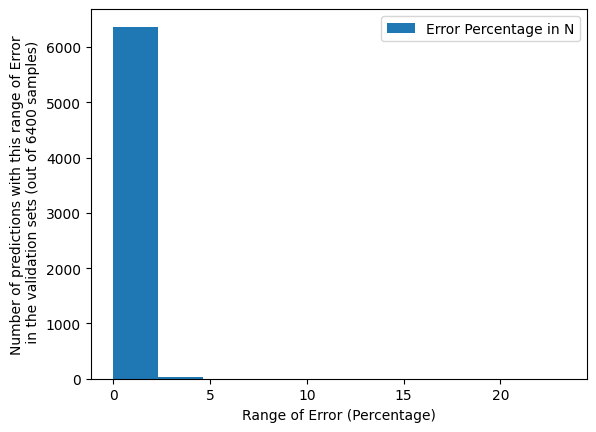

In [ ]:
plt.hist((abs((abs(y_true[:,0] )-abs(y_pred[:,0]))/(y_true[:,0]))*100), label = "Error Percentage in N")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 6400 samples)")
plt.xlabel("Range of Error (Percentage)")
plt.legend()

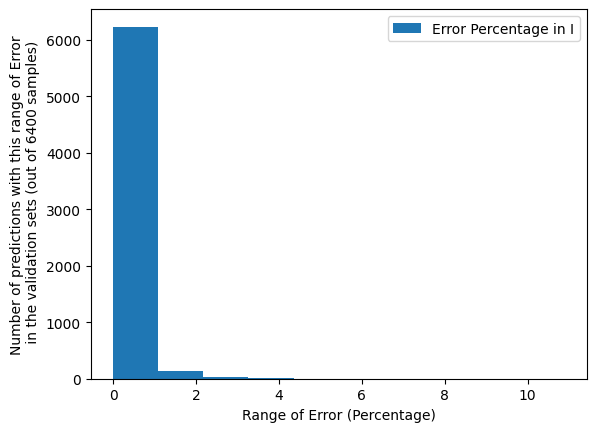

In [ ]:
plt.hist((abs((abs(y_true[:,1] )-abs(y_pred[:,1]))/(y_true[:,1]))*100), label = "Error Percentage in I")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 6400 samples)")
plt.xlabel("Range of Error (Percentage)")
plt.legend()

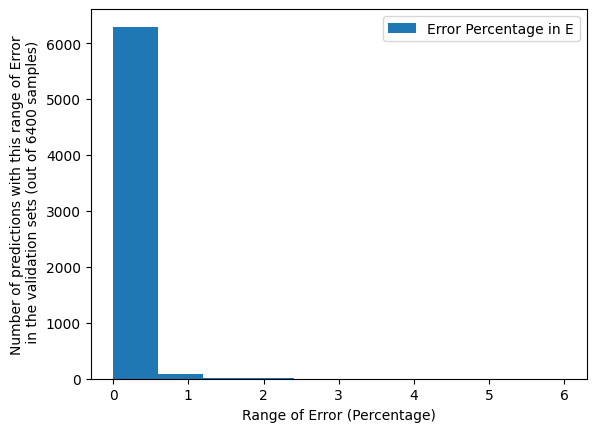

In [ ]:
plt.hist((abs((abs(y_true[:,2])-abs(y_pred[:,2]))/(y_true[:,2]))*100), label = "Error Percentage in E")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 6400 samples)")
plt.xlabel("Range of Error (Percentage)")
plt.legend()

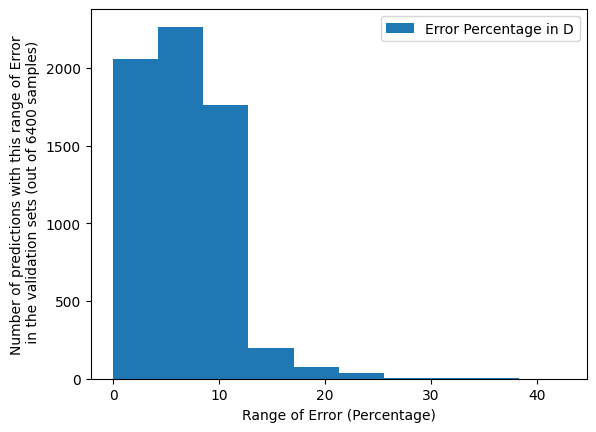

In [ ]:
plt.hist((abs((abs(y_true[:,3])-abs(y_pred[:,3]))/(y_true[:,3]))*100), label = "Error Percentage in D")
plt.ylabel("Number of predictions with this range of Error\n in the validation sets (out of 6400 samples)")
plt.xlabel("Range of Error (Percentage)")
plt.legend()